In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import warnings
from tqdm import tqdm

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score

## Loading data

In [2]:
#Convert Personality to DataFrame
personality = loadmat('data/Dt_Personality.mat')
personality = personality['Personality']
big5 = pd.DataFrame(personality, columns=['extro', 'agree', 'cons', 'stability', 'open'])
big5.head()

,extro,agree,cons,stability,open
0,5.4,5.9,5.2,5.1,5.2
1,3.0,5.1,4.3,3.7,4.6
2,3.9,5.4,4.4,4.8,3.9
3,2.9,4.1,5.6,5.7,4.0
4,3.2,4.8,6.1,5.7,4.7


In [3]:
ECG = loadmat('data/Dt_ECGFeatures.mat')
ECG_feats_mat = ECG['ECGFeatures_58']
ECG_fails_mat = ECG['ECGFailures_58'] #Ved ikke, om denne er nødvendig

In [4]:
def unfold_mat(mat, feats=None):
    #Returns list with each index being participant.
    #Each item has dataframe with shape video x feature (row is video, columns are features)
    lst = []
    for i in mat:
        d = pd.DataFrame(i, columns=feats)
        d.index += 1
        lst.append(d)
    
    return lst

def statistical_measurements(suffix):
    cols = []
    names = ['mean', 'std', 'skewness', 'kurtosis', '%time_over_mean+std', '%time_over_mean-std']
    for i in range(6):
        cols.append(names[i]+'_'+suffix)
    return cols

In [5]:
#Isolate ECG (Heart Monitor) Features
ECG_cols = ['low_freq_PSD' for x in range(10)]
[ECG_cols.append('slow_response_PSD') for x in range(4)]
[ECG_cols.append(x) for x in statistical_measurements('IBI')]
[ECG_cols.append(x) for x in statistical_measurements('HR')]
[ECG_cols.append(x) for x in statistical_measurements('HRV')]


ECG_feats = unfold_mat(ECG_feats_mat[0], feats=ECG_cols)

#Remove columns, where all rows are 0.0 or NaN
for i in range(len(ECG_feats)):
    ECG_feats[i] = ECG_feats[i].drop('low_freq_PSD', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('slow_response_PSD', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('mean_IBI', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('std_IBI', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('skewness_IBI', axis=1)
    ECG_feats[i] = ECG_feats[i].drop('kurtosis_IBI', axis=1)
    

ECG_feats[0].head()

,%time_over_mean+std_IBI,%time_over_mean-std_IBI,mean_HR,std_HR,skewness_HR,kurtosis_HR,%time_over_mean+std_HR,%time_over_mean-std_HR,mean_HRV,std_HRV,skewness_HRV,kurtosis_HRV,%time_over_mean+std_HRV,%time_over_mean-std_HRV
1,6.400031,6.444472,5.173039,5.276134,5.462701,5.173039,2.429736,1.114206,1.808920,6.739586,2.242985,-0.512542,-1.452407,0.752147
2,8.940823,8.484847,6.699335,7.280588,8.288437,6.699335,6.104294,3.374240,3.580793,5.524211,1.667694,1.235405,0.483075,0.979476
3,5.722146,8.025228,6.910288,6.106456,4.335125,6.910288,3.306808,2.661825,2.705716,6.734335,1.475662,-0.905105,-0.126162,0.996687
4,7.021727,6.146552,4.408273,4.635109,6.472956,4.408273,2.849756,1.988453,3.265623,6.658276,3.203142,-0.238137,0.429959,1.556095
5,8.947796,10.052068,9.149439,9.791126,7.806054,9.149439,5.423162,3.358165,3.213917,6.315864,0.412490,0.381669,-0.105420,1.579525


In [6]:
EEG = loadmat('data/Dt_EEGFeatures.mat')
EEG_feats_mat = EEG['EEGFeatures_58']
EEG_fails_mat = EEG['EEGFailures_58']

#Isolate EEG features
EEG_cols = []
[EEG_cols.append(x) for x in ['avg_first_deriv', 'prop_neg_diff_samples', 'mean_num_peaks', 'mean_deriv_inv_signal', 'avg_num_peaks_inv_signal']]
[EEG_cols.append(x) for x in statistical_measurements('EEG')]
[EEG_cols.append('attention') for x in range(11)]
[EEG_cols.append('meditation') for x in range(11)]
[EEG_cols.append('alpha') for x in range(11)]
[EEG_cols.append('beta') for x in range(11)]
[EEG_cols.append('delta') for x in range(11)]
[EEG_cols.append('gamma') for x in range(11)]
[EEG_cols.append('theta') for x in range(11)]

EEG_feats = unfold_mat(EEG_feats_mat[0], feats=EEG_cols)
EEG_feats[0].head()

,avg_first_deriv,prop_neg_diff_samples,mean_num_peaks,mean_deriv_inv_signal,avg_num_peaks_inv_signal,mean_EEG,std_EEG,skewness_EEG,kurtosis_EEG,%time_over_mean+std_EEG,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta
1,320.191443,82.717586,0.622098,8.653932,0.118051,0.103685,-0.035643,0.490625,0.719550,0.277515,...,57.904773,0.102995,2.389704,0.143660,0.178014,-0.057096,0.565000,0.099938,1.121837,0.099938
2,327.382886,72.859283,0.591914,7.812108,0.086196,0.091818,0.032656,0.477500,0.439725,-0.305716,...,26.303046,1.086900,4.005020,0.135540,0.144285,-0.058979,0.816875,0.059963,14.585341,0.059963
3,324.605247,55.293230,-0.068616,11.302303,0.085572,0.093691,0.017319,0.527500,0.579638,-0.135228,...,16.586558,1.009831,3.539354,0.154279,0.123048,-0.003508,0.595625,0.139913,3.494689,0.119925
4,324.935041,71.568548,0.099315,6.802679,0.108682,0.097439,0.009262,0.496875,0.339788,-0.099239,...,28.373115,0.142985,1.522516,0.217364,0.358526,-0.050226,0.691250,0.000000,25.022540,0.000000
5,324.365084,100.403114,1.107893,9.654450,0.084322,0.111181,-0.018255,0.526250,0.639600,0.108415,...,172.520834,1.180176,3.505648,0.165522,0.061836,-0.311222,0.715000,0.059963,1.625181,0.079950


In [7]:
GSR = loadmat('data/Dt_GSRFeatures.mat')
GSR_feats_mat = GSR['GSRFeatures_58']
GSR_fails_mat = GSR['GSRFailures_58']

GSR_cols = ['mean_resistance',
            'mean_derivative',
            'mean_differential_neg_values',
            'proportion_neg_derivative_samples',
            'num_local_signal_minima',
            'avg_rising_time',
            'spectral_power_Hz',
            'zero_crossing_slow',
            'zero_crossing_very_slow',
            'mean_scsr',
            'scvsr_peak_mag']


GSR_feats = unfold_mat(GSR_feats_mat[0])
GSR_feats[0].head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
1,33069.029095,-0.008551,0.046244,-0.041309,0.663229,24.238090,0.08,2.900391,8.352728,7.142155,...,-16.669073,-17.326377,-17.983548,-17.986607,-18.017055,-18.479243,0.20,0.007623,0.10,0.009376
2,32772.851127,0.037488,0.097698,-0.046883,0.642132,89.019954,0.06,3.687500,10.646847,8.804175,...,-14.099850,-15.059276,-16.648258,-15.725178,-15.450728,-16.216451,0.22,0.014270,0.08,0.040017
3,33118.800935,-0.081553,0.081693,-0.083999,0.971714,128.335403,0.04,0.503906,8.811834,5.869385,...,-15.165123,-15.954621,-16.952175,-16.646189,-16.513145,-17.115587,0.22,0.003287,0.06,0.020359
4,33424.208374,-0.027839,0.056428,-0.053708,0.784498,52.284710,0.12,1.268229,7.755704,7.366349,...,-18.169102,-18.591327,-18.957075,-19.269366,-19.529633,-19.756512,0.24,0.006474,0.14,0.005655
5,33119.419394,-0.004474,0.122433,-0.090331,0.702454,85.674875,0.06,3.692708,11.008999,9.159525,...,-13.946323,-14.601391,-15.318598,-15.299735,-15.293950,-15.766304,0.18,0.019813,0.10,0.031819


In [8]:
EMO = loadmat('data/Dt_EMOFeatures.mat')
EMO_feats_mat = EMO['EMOFeatures_58']
EMO_fails_mat = EMO['EMOFailures_58']

EMO_cols = []
[EMO_cols.append(x) for x in statistical_measurements('verti_upper_lip')]
[EMO_cols.append(x) for x in statistical_measurements('verti_lower_lip')]
[EMO_cols.append(x) for x in statistical_measurements('horis_left_lip')]
[EMO_cols.append(x) for x in statistical_measurements('verti_left_lip')]
[EMO_cols.append(x) for x in statistical_measurements('horis_right_lip')]
[EMO_cols.append(x) for x in statistical_measurements('verti_right_lip')]
[EMO_cols.append(x) for x in statistical_measurements('right_eyebrow')]
[EMO_cols.append(x) for x in statistical_measurements('left_eyebrow')]
[EMO_cols.append(x) for x in statistical_measurements('right_cheek')]
[EMO_cols.append(x) for x in statistical_measurements('left_cheek')]
[EMO_cols.append(x) for x in statistical_measurements('right_lid')]
[EMO_cols.append(x) for x in statistical_measurements('left_lid')]

EMO_feats = unfold_mat(EMO_feats_mat[0], feats=EMO_cols)
EMO_feats[0].head()

,mean_verti_upper_lip,std_verti_upper_lip,skewness_verti_upper_lip,kurtosis_verti_upper_lip,%time_over_mean+std_verti_upper_lip,%time_over_mean-std_verti_upper_lip,mean_verti_lower_lip,std_verti_lower_lip,skewness_verti_lower_lip,kurtosis_verti_lower_lip,...,skewness_right_lid,kurtosis_right_lid,%time_over_mean+std_right_lid,%time_over_mean-std_right_lid,mean_left_lid,std_left_lid,skewness_left_lid,kurtosis_left_lid,%time_over_mean+std_left_lid,%time_over_mean-std_left_lid
1,0.223020,0.219679,0.638564,3.262972,0.163,0.153,-0.010640,0.027353,-0.580092,3.944794,...,1.946301,7.265288,0.099,0.067,0.174646,0.261262,-2.982371,13.715942,0.056,0.057
2,0.212016,0.139533,-0.255579,3.051819,0.146,0.163,-0.006675,0.037458,-0.657221,3.349639,...,1.871134,8.520542,0.114,0.088,0.181886,0.080309,0.554708,4.517789,0.146,0.151
3,-0.280968,0.169713,-0.255870,3.240997,0.153,0.156,0.038117,0.045504,0.219787,2.908571,...,2.245768,13.520078,0.083,0.102,0.070183,0.317117,-1.679692,4.791623,0.030,0.154
4,0.370107,0.118877,0.650624,4.210562,0.128,0.143,0.023670,0.025453,0.262968,5.087146,...,2.726212,14.990869,0.080,0.058,-0.024757,0.066619,0.595670,5.135049,0.118,0.139
5,0.072518,0.143210,-0.023470,2.797568,0.158,0.160,-0.051663,0.055629,-0.248628,2.216479,...,3.103753,16.011740,0.068,0.052,0.086985,0.077744,-2.404924,38.241516,0.106,0.110


## Data preprocessing

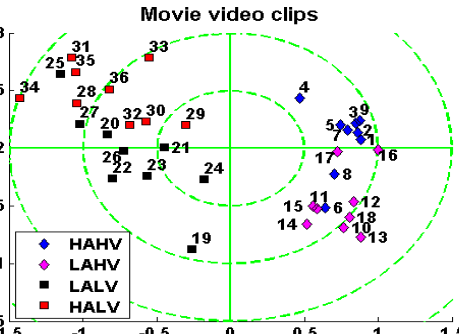

In [9]:
#Group movies into categories
HAHV = [1,2,3,4,5,6,7,8,9,10]
LAHV = [11,12,13,14,15,16,17,18],
LALV = [19,20,21,22,23,24,25,26,27]
HALV = [28,29,30,31,32,33,34,35,36]

In [125]:
def get_group(modality, group):
    #Returns a subset of modality after grouped movie clip
    #ex: get_group(EEG_feats, LAHV) -> list with dataframes, each is a participant, each row movie
    out = []
    for i in range(len(modality)):
        out.append(modality[i].loc[group])
    return out

def trait_binary(trait):
    median = np.median(big5.loc[:][trait].values)
    mask = big5.loc[:][trait]>median
    return mask.astype(int).values
    

def format_train_data(modality, trait, shuffle=False):
    vector_x = []
    vector_y = []
    
    bool5 = trait_binary(trait)
    
    for i, participant in enumerate(modality):
        participant.replace([np.inf, -np.inf], np.nan, inplace=True)
        participant = participant.dropna()
        y = bool5[i]
        
        for clip in participant.index:
            vector_x.append(participant.loc[clip].values)
            vector_y.append(y)
    
    vector_y = np.array(vector_y)
    vector_x = np.array(vector_x)
    if shuffle:
        vector_x, vector_y = sklearn.utils.shuffle(vector_x, vector_y, random_state=42)
        
    return vector_x, vector_y

def preprocess(features, target_trait):
    #Function, which returns standardized train/test X and y
    X, y = format_train_data(features, target_trait, shuffle=True)
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    return train_test_split(X, y, random_state=42)

def results(classifier):
    mats = {
        'EEG': EEG_feats,
        'ECG': ECG_feats,
        'EMO': EMO_feats,
        'GSR': GSR_feats
    }
    scores = []
    df = pd.DataFrame(columns=big5.keys(), index=['ECG', 'EEG', 'GSR', 'EMO'])
    for trait in tqdm(list(df.keys())):
        for modal in list(df.index):
            train_X, test_X, train_y, test_y = preprocess(mats[modal], trait)
            classifier.fit(train_X, train_y)
            preds = classifier.predict(test_X)
            df[trait][modal] = round(f1_score(preds, test_y),2)
            scores.append(f1_score(preds, test_y))
    print("Mean score:", np.mean(scores))
    print("STD score:", np.std(scores))
    
    return df

## Models

### Baseline (Should we even use it?)

In [126]:
dummy = DummyClassifier(random_state=42)
warnings.filterwarnings('ignore')
results(dummy)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

Mean score: 0.46672891703255137
STD score: 0.04514787060102672


,extro,agree,cons,stability,open
ECG,0.55,0.48,0.43,0.52,0.42
EEG,0.46,0.43,0.39,0.56,0.41
GSR,0.47,0.47,0.47,0.5,0.45
EMO,0.52,0.48,0.42,0.44,0.47


### Logistic Regression

In [127]:
warnings.filterwarnings('always')
logreg = LogisticRegressionCV(random_state=42, max_iter=2500, scoring='f1')
results(logreg)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.87s/it]

Mean score: 0.5641680857977104
STD score: 0.0806370875312237


,extro,agree,cons,stability,open
ECG,0.61,0.58,0.56,0.61,0.51
EEG,0.62,0.51,0.5,0.65,0.47
GSR,0.53,0.54,0.53,0.67,0.33
EMO,0.67,0.69,0.61,0.53,0.58


In [63]:
## Get optimal iterations and solver
# params_dist = {
#     'max_iter' : [500,1000,1500,2000],
#     'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
# }
# logreg = RandomizedSearchCV(logreg, params_dist, n_jobs=4, n_iter=10, random_state=42)
# random_search = logreg.fit(EEG_train_X, EEG_train_y)
# params = random_search.best_params_
'''Giver ikke meget mening med logistic regression - men overvej med MLPClassifier'''

Help on function filterwarnings in module warnings:

filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)
    Insert an entry into the list of warnings filters (at the front).
    
    'action' -- one of "error", "ignore", "always", "default", "module",
                or "once"
    'message' -- a regex that the warning message must match
    'category' -- a class that the warning must be a subclass of
    'module' -- a regex that the module name must match
    'lineno' -- an integer line number, 0 matches all warnings
    'append' -- if true, append to the list of filters

